In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# BLEU scores data
data_bleu = {
    "window_size": ["w16", "w32", "w64", "w128"],
    "de-en": [29.37, 28.24, 29.40, 30.49],
    "en-de": [24.12, 23.20, 24.41, 24.85],
}

# COMET scores data
data_comet = {
    "window_size": ["w16", "w32", "w64", "w128"],
    "de-en": [77.19, 76.44, 77.56, 77.98],
    "en-de": [72.88, 72.22, 72.98, 73.58],
}

df_bleu = pd.DataFrame(data_bleu)
df_comet = pd.DataFrame(data_comet)

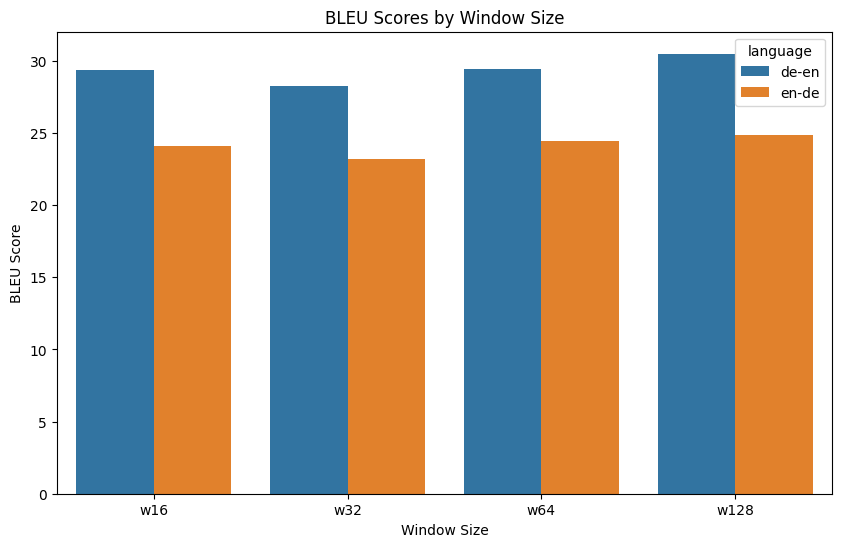

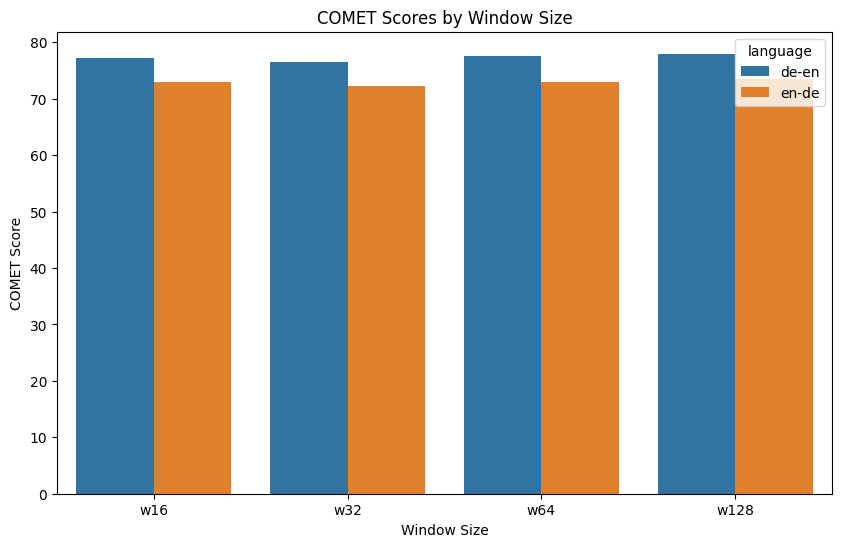

In [2]:
# Plot for BLEU scores
plt.figure(figsize=(10, 6))
sns.barplot(
    x="window_size",
    y="value",
    hue="language",
    data=pd.melt(
        df_bleu,
        id_vars=["window_size"],
        value_vars=["de-en", "en-de"],
        var_name="language",
        value_name="value",
    ),
)
plt.title("BLEU Scores by Window Size")
plt.xlabel("Window Size")
plt.ylabel("BLEU Score")
plt.show()

# Plot for COMET scores
plt.figure(figsize=(10, 6))
sns.barplot(
    x="window_size",
    y="value",
    hue="language",
    data=pd.melt(
        df_comet,
        id_vars=["window_size"],
        value_vars=["de-en", "en-de"],
        var_name="language",
        value_name="value",
    ),
)
plt.title("COMET Scores by Window Size")
plt.xlabel("Window Size")
plt.ylabel("COMET Score")
plt.show()

/tmp/ipykernel_2123364/131077895.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("winter", n)  # 'n' is the number of unique colors needed


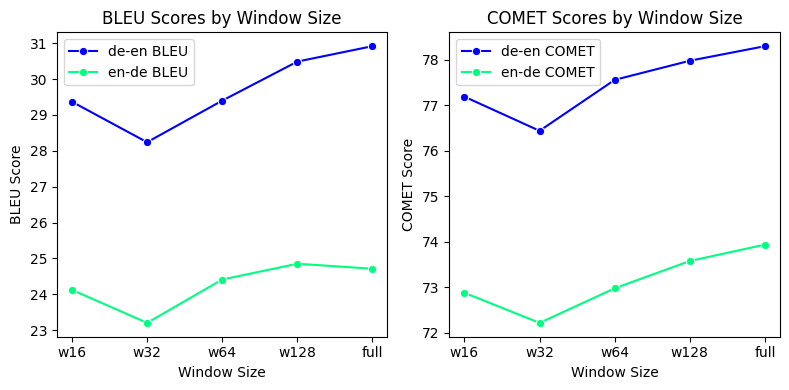

In [7]:
# Adjusting the plot to have distinguishable colors for each line within the "winter" color palette

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n = 2
cmap = plt.cm.get_cmap("winter", n)  # 'n' is the number of unique colors needed
colors = [cmap(i) for i in range(n)]


plt.figure(figsize=(8, 4))

# BLEU Scores Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.lineplot(
    data=df_bleu,
    x="Window Size",
    y="de-en BLEU",
    marker="o",
    label="de-en BLEU",
    color=colors[0],
)
sns.lineplot(
    data=df_bleu,
    x="Window Size",
    y="en-de BLEU",
    marker="o",
    label="en-de BLEU",
    color=colors[1],
)
plt.title("BLEU Scores by Window Size")
plt.ylabel("BLEU Score")
plt.xlabel("Window Size")

# COMET Scores Plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.lineplot(
    data=df_comet,
    x="Window Size",
    y="de-en COMET",
    marker="o",
    label="de-en COMET",
    color=colors[0],
)
sns.lineplot(
    data=df_comet,
    x="Window Size",
    y="en-de COMET",
    marker="o",
    label="en-de COMET",
    color=colors[1],
)
plt.title("COMET Scores by Window Size")
plt.ylabel("COMET Score")
plt.xlabel("Window Size")

plt.tight_layout()
plt.savefig(f"plots/window_abalations.pdf")

plt.show()

In [2]:
import json


models = [
    "retnet",
    "mamba",
    "llama", 
    "transformer_encdec",
    'mamba_mha',
    'mamba_mistral',
    'mamba_encdec'
]
name_map = {"llama": "transformer++", "mamba_mistral": "mamba_local"}
model_names = [
    name_map[model] if model in name_map else model
    for model in models
]
model_names
spans = [json.load(open(f"mt/res/iwslt17/xcomet_{model}.json")) for model in models]

In [6]:
len(spans[0]['scores'])

8079

In [2]:
def count_error_spans(gen):

    n_samples = len(gen["metadata"]["error_spans"])
 
    unroll = [x for sample in gen["metadata"]["error_spans"] for x in sample]
    n_spans = len(unroll)

    minor, major, critical  = 0, 0, 0

    for span in unroll:
        if span["severity"] == "minor":
            minor += 1
        elif span["severity"] == "major":
            major += 1
        elif span["severity"] == "critical":
            critical += 1

    return n_samples, n_spans, minor, major, critical

out = [(model, count_error_spans(gen)) for model,gen in zip(models, spans)]   
out

[('retnet', (8079, 14364, 4013, 8177, 2174)),
 ('mamba', (8079, 13962, 4597, 7498, 1867)),
 ('llama', (8079, 13965, 4699, 7527, 1739)),
 ('transformer_encdec', (8079, 13604, 4671, 7413, 1520)),
 ('mamba_mha', (8079, 13627, 5562, 6952, 1113)),
 ('mamba_mistral', (8079, 13017, 5255, 6518, 1244)),
 ('mamba_encdec', (8079, 13566, 5546, 7032, 988))]

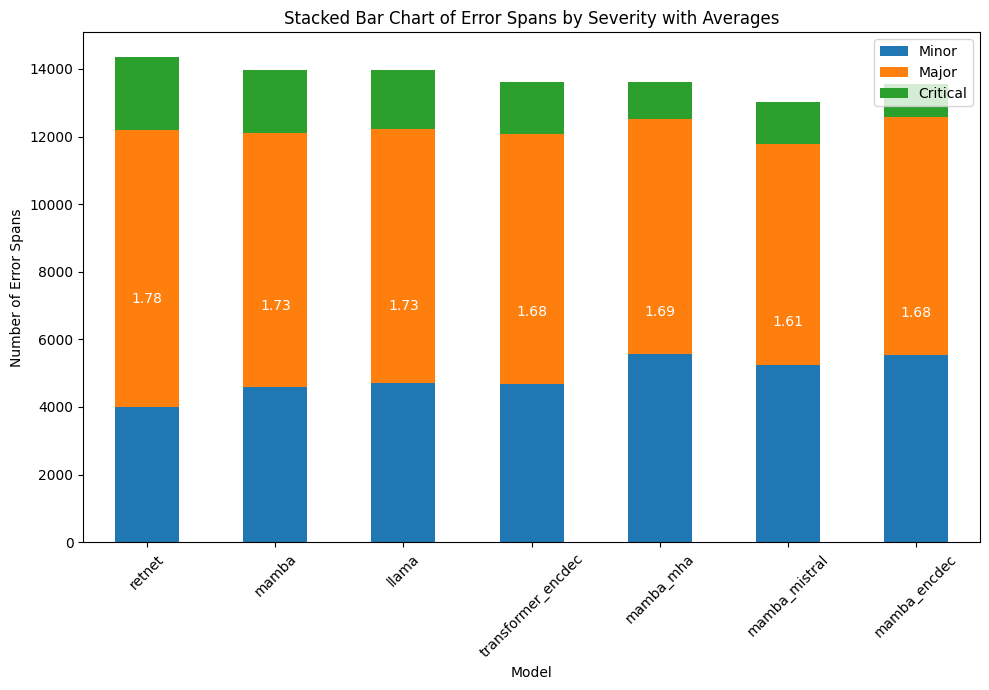

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


average_error_spans_per_sample = [(x[0], x[1][1] / x[1][0]) for x in out]

# Creating outFrame
df = pd.DataFrame(
    {
        "Model": [x[0] for x in out],
        "Minor": [x[1][2] for x in out],
        "Major": [x[1][3] for x in out],
        "Critical": [x[1][4] for x in out],
    }
)

# Set index to 'Model' for easier plotting
df.set_index("Model", inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
df.plot(kind="bar", stacked=True, ax=ax)
ax.set_ylabel("Number of Error Spans")
ax.set_title("Stacked Bar Chart of Error Spans by Severity with Averages")

# Adding the average error spans per sample as text inside the bars
totals = df.sum(axis=1)  # Total height of each stacked bar
for i, total in enumerate(totals):
    ax.text(
        i,
        total / 2,
        f"{average_error_spans_per_sample[i][1]:.2f}",
        ha="center",
        va="center",
        color="white",
        fontsize=10,
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:
from scripts.ar import *

source, target = "de", "en"
dataset = "iwslt17"
ds = build_dataset(dataset, source, target, is_encoder_decoder=False)
tokenizer = ds.get_tokenizer()  # Extract tokenizer

models = [
    "transformer_encdec",
    "llama",
    "retnet",
    "mamba",
    "mamba_mha",
    "mamba_mistral",
    "mamba_encdec",
]


name_map = {"llama": "transformer++", "mamba_mistral": "mamba_local"}
model_names = [name_map[model] if model in name_map else model for model in models]
spans = [json.load(open(f"mt/res/iwslt17/xcomet_{model}.json")) for model in models]

/home/hugo/.pyenv/versions/3.10.4/envs/ctxeff/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/hugo/.pyenv/versions/3.10.4/envs/ctxeff/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/hugo/.pyenv/versions/3.10.4/envs/ctxeff/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Please install tensorboardX: pip install tensorboardX
[nltk_data] Downloading package punkt to /home/hugo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading

/tmp/ipykernel_3049705/1686975163.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("winter", n)  # 'n' is the number of unique colors needed


{0: [342, 132, 11, 987], 8: [1359, 966, 181, 2598], 16: [1123, 1454, 298, 1896], 24: [859, 1335, 284, 1142], 32: [785, 1931, 416, 1024], 48: [203, 1595, 330, 432]}
{0: [349, 130, 18, 987], 8: [1442, 996, 213, 2598], 16: [1197, 1405, 318, 1896], 24: [821, 1427, 352, 1142], 32: [707, 2024, 430, 1024], 48: [183, 1545, 408, 432]}
{0: [384, 137, 16, 987], 8: [1407, 1043, 221, 2598], 16: [1074, 1586, 401, 1896], 24: [583, 1629, 411, 1142], 32: [503, 2244, 604, 1024], 48: [62, 1538, 521, 432]}
{0: [354, 128, 23, 987], 8: [1470, 904, 175, 2598], 16: [1136, 1456, 359, 1896], 24: [857, 1469, 269, 1142], 32: [654, 2090, 534, 1024], 48: [126, 1451, 507, 432]}
{0: [360, 133, 9, 987], 8: [1551, 865, 146, 2598], 16: [1307, 1285, 278, 1896], 24: [982, 1258, 218, 1142], 32: [960, 1893, 263, 1024], 48: [402, 1518, 199, 432]}
{0: [367, 140, 25, 987], 8: [1423, 918, 149, 2598], 16: [1325, 1277, 249, 1896], 24: [979, 1216, 244, 1142], 32: [914, 1869, 277, 1024], 48: [247, 1098, 300, 432]}
{0: [354, 131, 18

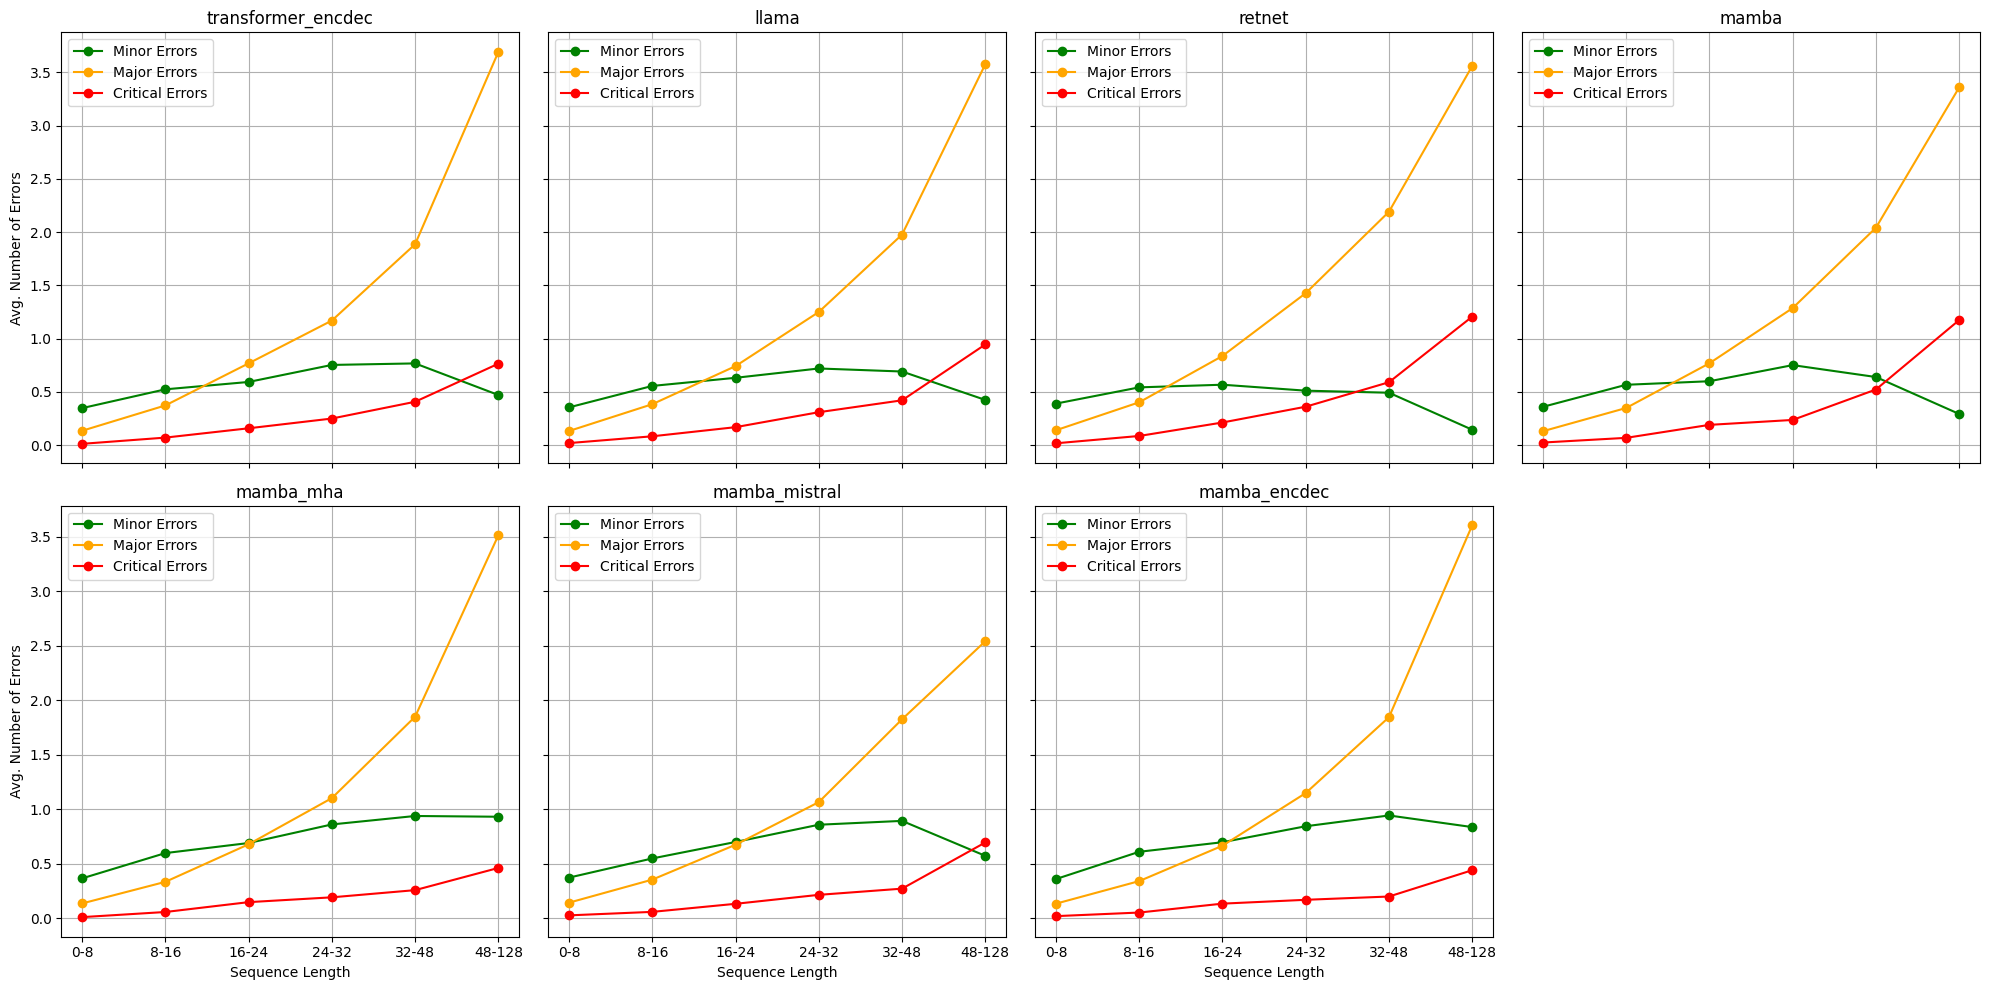

In [26]:
import pandas as pd

# Assuming 'ds' and 'tokenizer' are already defined as you specified
sequence_lengths = []
for sample_idx in range(len(ds.dataset["test"])):
    src = ds.dataset["test"][sample_idx]["translation"][source]
    n_tokens = len(tokenizer(src)["input_ids"])
    sequence_lengths.append(n_tokens)


# Define bins
bins = [0, 8, 16, 24, 32, 48,  128]
binned_lengths = pd.cut(sequence_lengths, bins=bins, labels=bins[:-1])
def count_error_spans_by_bin(gen, binned_lengths):
    errors_by_bin = {
        bin_label: [0, 0, 0, 0] for bin_label in bins[:-1]
    }  # Adding an extra count for number of samples

    for sample_idx, error_spans in enumerate(gen["metadata"]["error_spans"]):
        bin_label = binned_lengths[sample_idx]
        errors_by_bin[bin_label][3] += 1  # Increment sample count
        for span in error_spans:
            if span["severity"] == "minor":
                errors_by_bin[bin_label][0] += 1
            elif span["severity"] == "major":
                errors_by_bin[bin_label][1] += 1
            elif span["severity"] == "critical":
                errors_by_bin[bin_label][2] += 1

    print(errors_by_bin)
    # Convert total counts to averages
    for bin_label in errors_by_bin:
        total_samples = errors_by_bin[bin_label][3]
        if total_samples > 0:
            errors_by_bin[bin_label] = [
                x / total_samples for x in errors_by_bin[bin_label][:3]
            ]
        else:
            errors_by_bin[bin_label] = [
                0,
                0,
                0,
            ]  # Avoid division by zero by setting averages to 0

    return errors_by_bin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_error_spans(models, spans, bins):
    n = len(models)
    cmap = plt.cm.get_cmap("winter", n)  # 'n' is the number of unique colors needed
    colors = [cmap(i) for i in range(n)]
    bucket_labels = [f"{int(bins[i-1])}-{int(bins[i])}" for i in range(1, len(bins))]

    fig, axs = plt.subplots(
        nrows=2, ncols=4, figsize=(20, 10), sharey="row", sharex="col"
    )  # 2 rows, 4 columns, shared axes
    flat_axs = axs.flatten()

    for idx, (model, ax) in enumerate(zip(models, flat_axs)):
        spans_data = json.load(open(f"mt/res/iwslt17/xcomet_{model}.json"))
        error_counts_by_bin = count_error_spans_by_bin(spans_data, binned_lengths)



        # Ensure DataFrame is indexed with the bucket labels
        df = pd.DataFrame(error_counts_by_bin, index=["Minor", "Major", "Critical"]).T
        df.index = bucket_labels  # Reindex DataFrame to match bucket_labels

        # Plot each error type separately
        ax.plot(
            bucket_labels, df["Minor"], marker="o", label="Minor Errors", color="green"
        )
        ax.plot(
            bucket_labels, df["Major"], marker="o", label="Major Errors", color="orange"
        )
        ax.plot(
            bucket_labels,
            df["Critical"],
            marker="o",
            label="Critical Errors",
            color="red",
        )

        ax.set_title(model)
        if idx % 4 == 0:  # First column of each row
            ax.set_ylabel("Avg. Number of Errors")
        if idx >= 4:  # Second row
            ax.set_xlabel("Sequence Length")
        ax.legend(loc="upper left")
        ax.grid(True)

    # Turn off unused axes if the number of models is less than the number of subplots
    for unused_ax in flat_axs[len(models) :]:
        unused_ax.axis("off")

    plt.tight_layout()
    plt.show()


# Usage
plot_error_spans(models, spans, bins)

(<Axes: >,
 0      987
 8     2598
 16    1896
 24    1142
 32    1024
 48     432
 Name: count, dtype: int64)

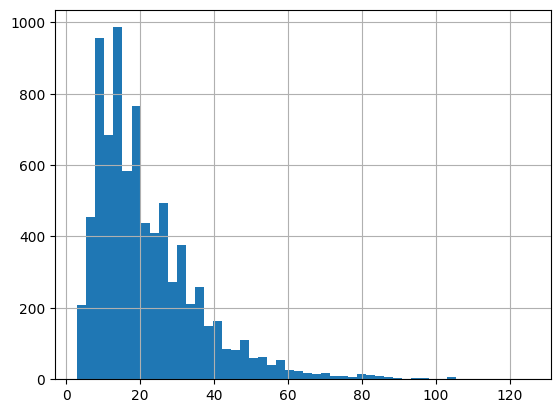

In [49]:
pd.Series(sequence_lengths).hist(bins=50), binned_lengths.value_counts()

0      987
8     2598
16    1896
24    1142
32    1024
48     432
Name: count, dtype: int64

In [ ]:
def count_error_spans_by_length(spans, ds, tokenizer, source, bin_size=20):
    error_data = {"minor": {}, "major": {}, "critical": {}}
    count_data = {"minor": {}, "major": {}, "critical": {}}

    for sample_idx, error_spans in enumerate(spans["metadata"]["error_spans"]):
        # Retrieve the source sentence based on the dataset structure
        src = (
            ds.dataset["test"][sample_idx]["translation"][source]
            if "translation" in ds.dataset["test"][sample_idx]
            else ds.dataset["test"][sample_idx][source]
        )
        n_tokens = len(tokenizer(src)["input_ids"])  # Tokenize the source sentence

        # Initialize dictionary keys if they do not exist for this token count
        if n_tokens not in error_data["minor"]:
            error_data["minor"][n_tokens] = 0
            error_data["major"][n_tokens] = 0
            error_data["critical"][n_tokens] = 0

            count_data["minor"][n_tokens] = 0
            count_data["major"][n_tokens] = 0
            count_data["critical"][n_tokens] = 0

        # Count errors by severity
        for span in error_spans:
            if span["severity"] == "minor":
                error_data["minor"][n_tokens] += 1
            elif span["severity"] == "major":
                error_data["major"][n_tokens] += 1
            elif span["severity"] == "critical":
                error_data["critical"][n_tokens] += 1

            count_data[span["severity"]][n_tokens] += 1


    # Calculate average number of errors per sample per category for each bin
    avg_error_data = {"minor": {}, "major": {}, "critical": {}}
    for severity in error_data:
        for token_length, count in count_data[severity].items():
            binned_length = (token_length // bin_size) * bin_size
            if count > 0:
                avg_error_data[severity][binned_length] = (
                    error_data[severity][token_length] / count
                )
            else:
                avg_error_data[severity][binned_length] = 0

    return avg_error_data, error_data, count_data

out, err, cnt = count_error_spans_by_length(spans[0], ds, tokenizer, source)

In [ ]:
cnt['minor']

{32: 51,
 44: 21,
 9: 168,
 24: 118,
 26: 98,
 7: 131,
 57: 1,
 15: 190,
 19: 128,
 21: 116,
 45: 13,
 48: 16,
 38: 50,
 18: 136,
 31: 55,
 23: 139,
 10: 143,
 22: 116,
 6: 71,
 17: 164,
 16: 173,
 40: 13,
 8: 139,
 14: 198,
 13: 174,
 20: 157,
 12: 176,
 11: 185,
 34: 45,
 4: 6,
 25: 94,
 33: 59,
 27: 109,
 5: 36,
 36: 48,
 39: 33,
 69: 2,
 56: 8,
 35: 49,
 28: 59,
 37: 46,
 3: 1,
 46: 25,
 53: 4,
 51: 12,
 29: 77,
 42: 30,
 54: 2,
 83: 0,
 72: 0,
 30: 40,
 68: 0,
 59: 3,
 73: 0,
 55: 7,
 47: 24,
 52: 5,
 49: 5,
 50: 7,
 41: 26,
 43: 5,
 84: 0,
 58: 0,
 61: 0,
 62: 0,
 67: 0,
 63: 0,
 80: 0,
 88: 0,
 74: 0,
 66: 0,
 77: 1,
 60: 3,
 79: 0,
 75: 0,
 103: 0,
 78: 0,
 98: 0,
 105: 0,
 64: 2,
 85: 0,
 71: 0,
 97: 0,
 76: 0,
 102: 0,
 70: 0,
 82: 0,
 81: 0,
 89: 0,
 125: 0,
 87: 0,
 96: 0,
 94: 0,
 104: 0,
 65: 0,
 100: 0,
 95: 0,
 93: 0}

In [4]:

# Collect error data by length for all models
error_data_by_model = {}
for model, model_spans in zip(models, spans):
    error_data_by_model[model] = count_error_spans_by_length(
        model_spans, ds, tokenizer, source
    )

# Assuming a plotting or summary function exists, you would pass error_data_by_model to it
# For example: plot_error_distribution_by_length(models, error_data_by_model)

/home/hugo/.pyenv/versions/3.10.4/envs/ctxeff/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/hugo/.pyenv/versions/3.10.4/envs/ctxeff/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/hugo/.pyenv/versions/3.10.4/envs/ctxeff/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Please install tensorboardX: pip install tensorboardX
[nltk_data] Downloading package punkt to /home/hugo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading

In [7]:
error_data_by_model

{'retnet': {'minor': {20: 1.0, 40: 0, 0: 1.0, 60: 0, 80: 0, 100: 0, 120: 0},
  'major': {20: 1.0, 40: 1.0, 0: 1.0, 60: 1.0, 80: 0, 100: 1.0, 120: 0},
  'critical': {20: 1.0, 40: 1.0, 0: 0, 60: 1.0, 80: 0, 100: 1.0, 120: 0}},
 'mamba': {'minor': {20: 1.0, 40: 1.0, 0: 1.0, 60: 0, 80: 0, 100: 0, 120: 0},
  'major': {20: 1.0, 40: 1.0, 0: 1.0, 60: 1.0, 80: 1.0, 100: 0, 120: 1.0},
  'critical': {20: 1.0, 40: 1.0, 0: 0, 60: 1.0, 80: 1.0, 100: 1.0, 120: 0}},
 'llama': {'minor': {20: 1.0, 40: 1.0, 0: 1.0, 60: 1.0, 80: 0, 100: 0, 120: 0},
  'major': {20: 1.0, 40: 1.0, 0: 1.0, 60: 1.0, 80: 0, 100: 1.0, 120: 1.0},
  'critical': {20: 1.0, 40: 1.0, 0: 1.0, 60: 1.0, 80: 1.0, 100: 0, 120: 0}},
 'transformer_encdec': {'minor': {20: 1.0,
   40: 1.0,
   0: 1.0,
   60: 0,
   80: 0,
   100: 0,
   120: 0},
  'major': {20: 1.0, 40: 1.0, 0: 1.0, 60: 1.0, 80: 1.0, 100: 1.0, 120: 1.0},
  'critical': {20: 1.0, 40: 1.0, 0: 0, 60: 0, 80: 1.0, 100: 0, 120: 1.0}},
 'mamba_mha': {'minor': {20: 1.0,
   40: 1.0,
   0: 

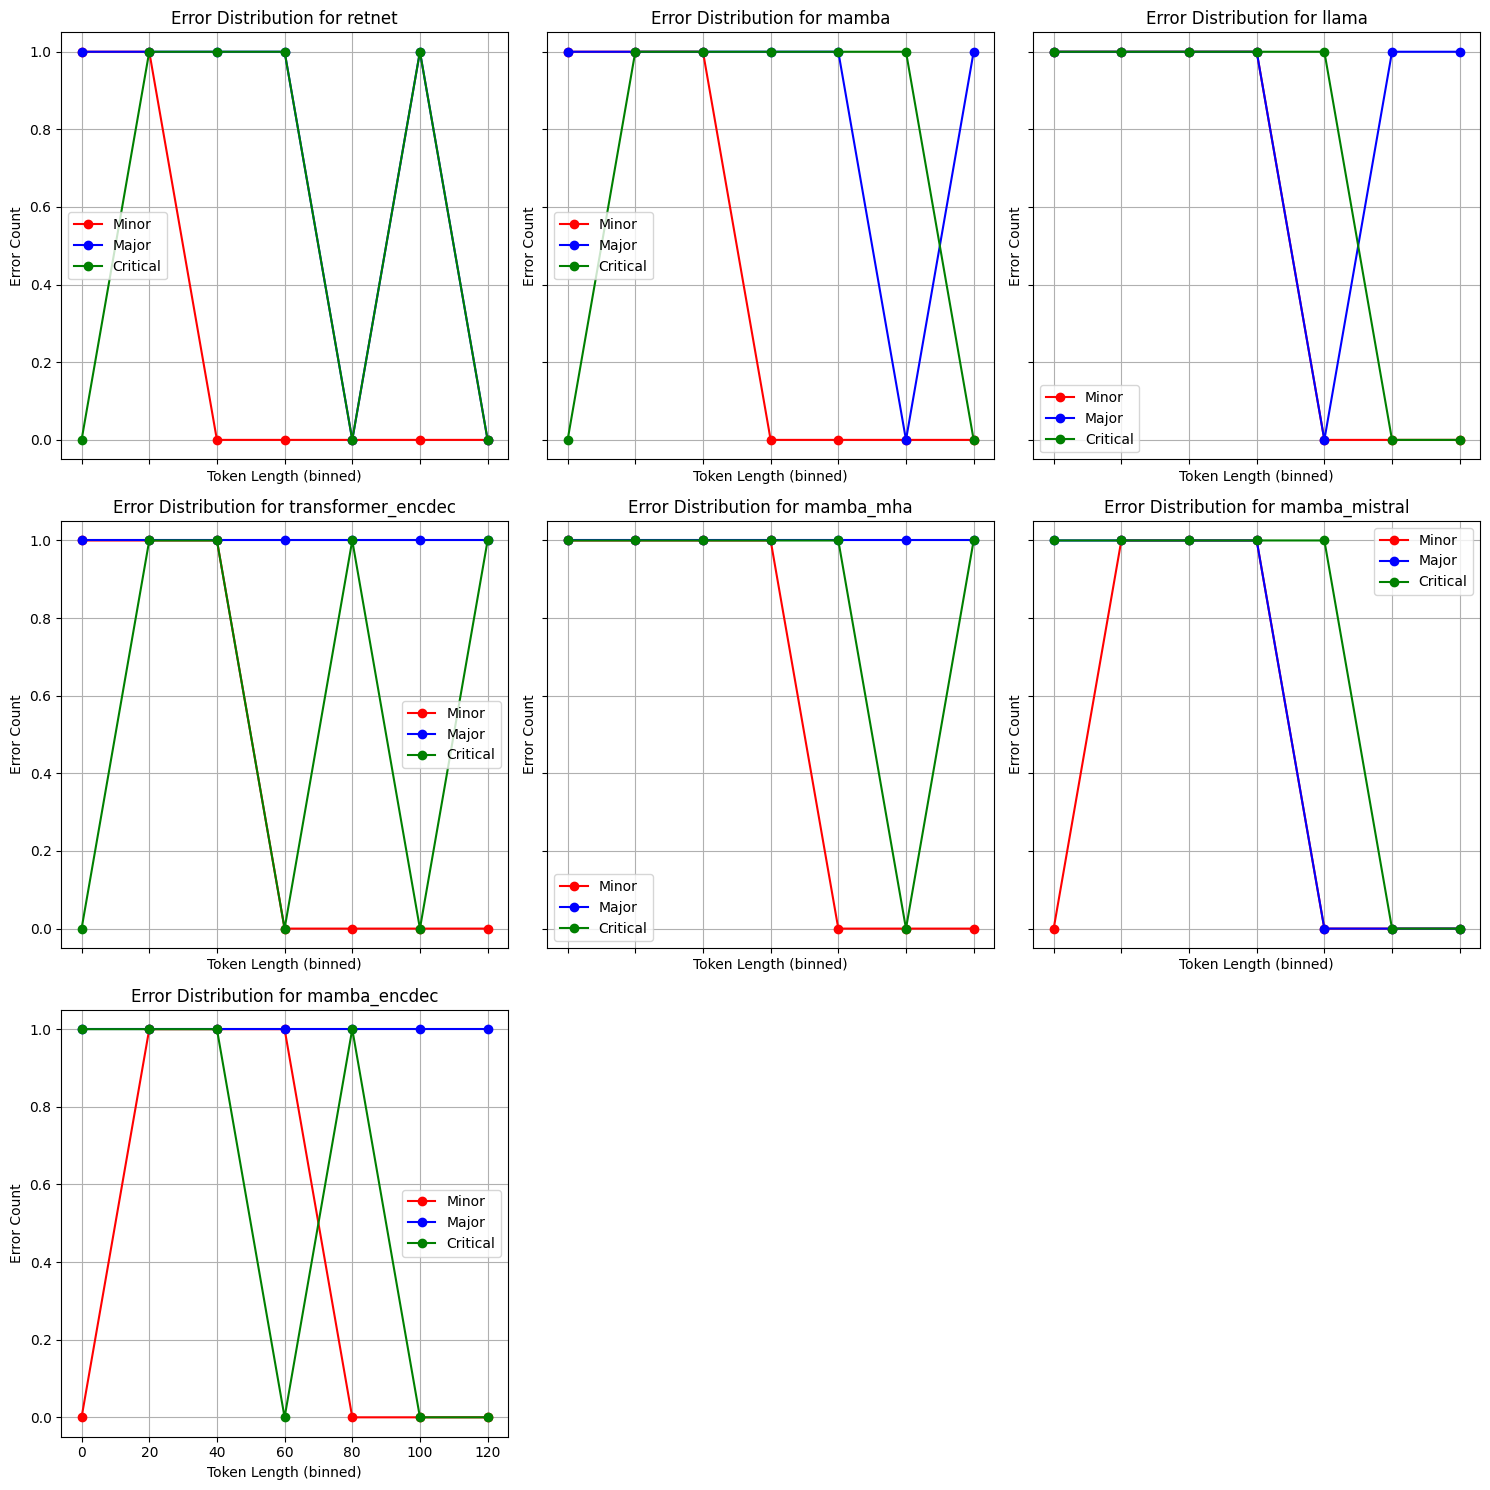

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def plot_error_distribution_by_model(models, error_data_by_model, bin_size=20):
    colors = {"minor": "red", "major": "blue", "critical": "green"}
    severity_levels = ["minor", "major", "critical"]
    n_models = len(models)
    ncols = 3  # Adjustable based on how many columns you want per row
    nrows = int(np.ceil(n_models / ncols))

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), sharex=True, sharey=True
    )
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    for idx, model in enumerate(models):
        ax = axes[idx]
        all_data = {}

        # Initialize binned data dictionary
        for severity in severity_levels:
            all_data[severity] = {}

        # Aggregate data into bins
        for severity in severity_levels:
            for token_length, count in error_data_by_model[model][severity].items():
                binned_length = (token_length // bin_size) * bin_size
                if binned_length not in all_data[severity]:
                    all_data[severity][binned_length] = 0
                all_data[severity][binned_length] += count

        # Plotting
        for severity in severity_levels:
            if all_data[severity]:
                token_lengths = sorted(all_data[severity].keys())
                error_counts = [all_data[severity][length] for length in token_lengths]
                ax.plot(
                    token_lengths,
                    error_counts,
                    label=f"{severity.capitalize()}",
                    color=colors[severity],
                    marker="o",
                )

        ax.set_title(f"Error Distribution for {model}")
        ax.set_xlabel("Token Length (binned)")
        ax.set_ylabel("Error Count")
        ax.grid(True)
        ax.legend()

    # Hide unused subplots if any
    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


# Assuming error_data_by_model has been populated as described earlier
plot_error_distribution_by_model(models, error_data_by_model)

In [86]:
import pandas as pd

df = pd.read_csv("de-en.tsv", sep="\t")
df['index'] = df.index
df.head()

,source,reference,lp,index
0,news,azonline.de.103875,de-en,0
1,news,azonline.de.103875,de-en,1
2,news,bergedorfer-zeitung.de.12786,de-en,2
3,news,bergedorfer-zeitung.de.12786,de-en,3
4,news,bergedorfer-zeitung.de.12786,de-en,4


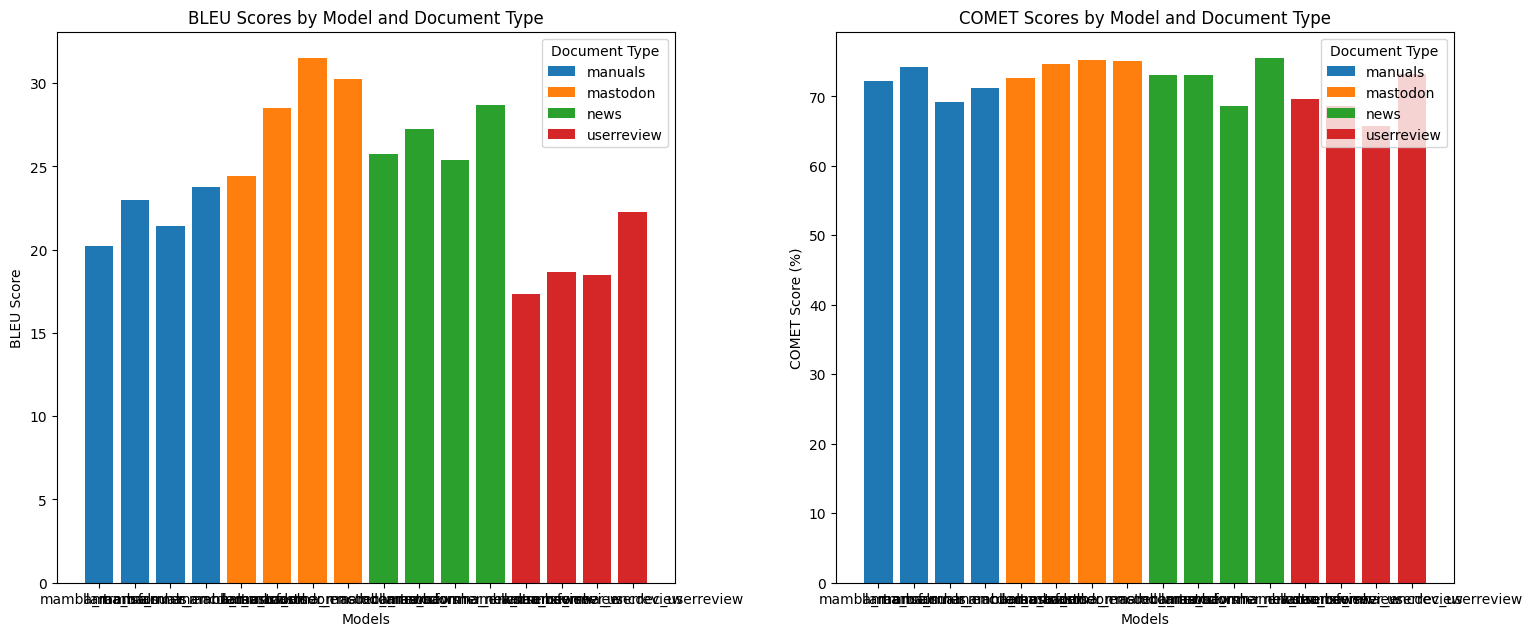

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Adjusted function assuming gens and df are already correctly defined and populated
def get_scores_by_type(gens, df):
    # Adjust this part according to the structure of gens
    gens_df = pd.DataFrame(
        {
            "index": [x[0] for x in gens],
            "BLEU": [x[1][3] for x in gens],
            "COMET": [x[1][4] for x in gens],  # Convert COMET scores to percentage
        }
    )
    # Convert COMET score scale from 0-1 to 0-100
    gens_df["COMET"] = gens_df["COMET"].apply(lambda x: x * 100)

    merged_df = pd.merge(df, gens_df, on="index")
    average_scores = merged_df.groupby("source").agg({"BLEU": "mean", "COMET": "mean"})
    return average_scores


# Assuming models and gens are defined
models = ["mabma", "llama", "mamba_mha", "transformer_encdec"]
all_scores = {model: get_scores_by_type(gens[i], df) for i, model in enumerate(models)}

# Creating a combined DataFrame
scores_list = []
for model, scores in all_scores.items():
    scores_reset = scores.reset_index()
    scores_reset["Model"] = model
    scores_list.append(scores_reset)
combined_scores = pd.concat(scores_list)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), dpi=100)

# BLEU Scores Plot
for doc_type, group in combined_scores.groupby("source"):
    axes[0].bar(group["Model"] + "_" + doc_type, group["BLEU"], label=f"{doc_type}")

axes[0].set_title("BLEU Scores by Model and Document Type")
axes[0].set_ylabel("BLEU Score")
axes[0].set_xlabel("Models")
axes[0].legend(title="Document Type")

# COMET Scores Plot
for doc_type, group in combined_scores.groupby("source"):
    axes[1].bar(group["Model"] + "_" + doc_type, group["COMET"], label=f"{doc_type}")

axes[1].set_title("COMET Scores by Model and Document Type")
axes[1].set_ylabel("COMET Score (%)")
axes[1].set_xlabel("Models")
axes[1].legend(title="Document Type")

# Adjust layout
plt.tight_layout(pad=3.0)
# plt.subplots_adjust(wspace=0.35)  # Adjust the space between subplots
plt.show()

In [79]:
import pandas as pd

# Example usage of the build_dataset and tokenizer functions
from mt.ds import build_dataset

ds = build_dataset("wmt23-6M", "de", "en", is_encoder_decoder=False)
tok = ds.get_tokenizer()


# Adjusted function assuming gens and df are already correctly defined and populated
def get_scores_by_type(gens, df, tokenizer):
    # Creating a DataFrame from gens assuming gens structure provided
    gens_df = pd.DataFrame(
        {
            "index": [x[0] for x in gens],
            "src": [x[1][0] for x in gens],
            "BLEU": [x[1][3] for x in gens],
            "COMET": [x[1][4] for x in gens],
        }
    )

    # Convert COMET score scale from 0-1 to 0-100
    gens_df["COMET"] = gens_df["COMET"].apply(lambda x: x * 100)

    # Tokenize the src texts and count tokens
    gens_df["token_count"] = gens_df["src"].apply(lambda text: len(tokenizer(text)['input_ids']))

    # Merge gens_df with df on index
    merged_df = pd.merge(df, gens_df, on="index")

    # Calculate average scores and average token count by source
    average_data = merged_df.groupby("source").agg(
        {"BLEU": "mean", "COMET": "mean", "token_count": "mean"}
    )

    return average_data


# Assuming models and gens are defined
models = ["mamba", "llama", "mamba_mha", "transformer_encdec"]

# Calculate the data for each model
results = [
    (model, get_scores_by_type(gens[i], df, tok)) for i, model in enumerate(models)
]

In [80]:
results

[('mamba',
                   BLEU      COMET  token_count
  source                                       
  manuals     20.245588  72.202280   114.959459
  mastodon    24.404195  72.599363    30.300971
  news        25.766984  73.032773    59.592058
  userreview  17.354417  69.564145   101.863158),
 ('llama',
                   BLEU      COMET  token_count
  source                                       
  manuals     23.013366  74.260980   114.959459
  mastodon    28.512308  74.607479    30.300971
  news        27.252903  73.050400    59.592058
  userreview  18.663739  68.593750   101.863158),
 ('mamba_mha',
                   BLEU      COMET  token_count
  source                                       
  manuals     21.430397  69.180215   114.959459
  mastodon    31.522111  75.210482    30.300971
  news        25.366876  68.648113    59.592058
  userreview  18.484077  65.686678   101.863158),
 ('transformer_encdec',
                   BLEU      COMET  token_count
  source             

In [101]:
import numpy as np

ds = build_dataset("wmt23-6M", "de", "en", is_encoder_decoder=False)
tok = ds.get_tokenizer()



val_lens = [len(tok(sample)["input_ids"]) for sample in ds.dataset["validation"]]
test_lens = [len(tok(sample)["input_ids"]) for sample in ds.dataset["test"]["de"]]


np.mean(val_lens), np.mean(test_lens) 

(134.73869346733667, 68.8816029143898)

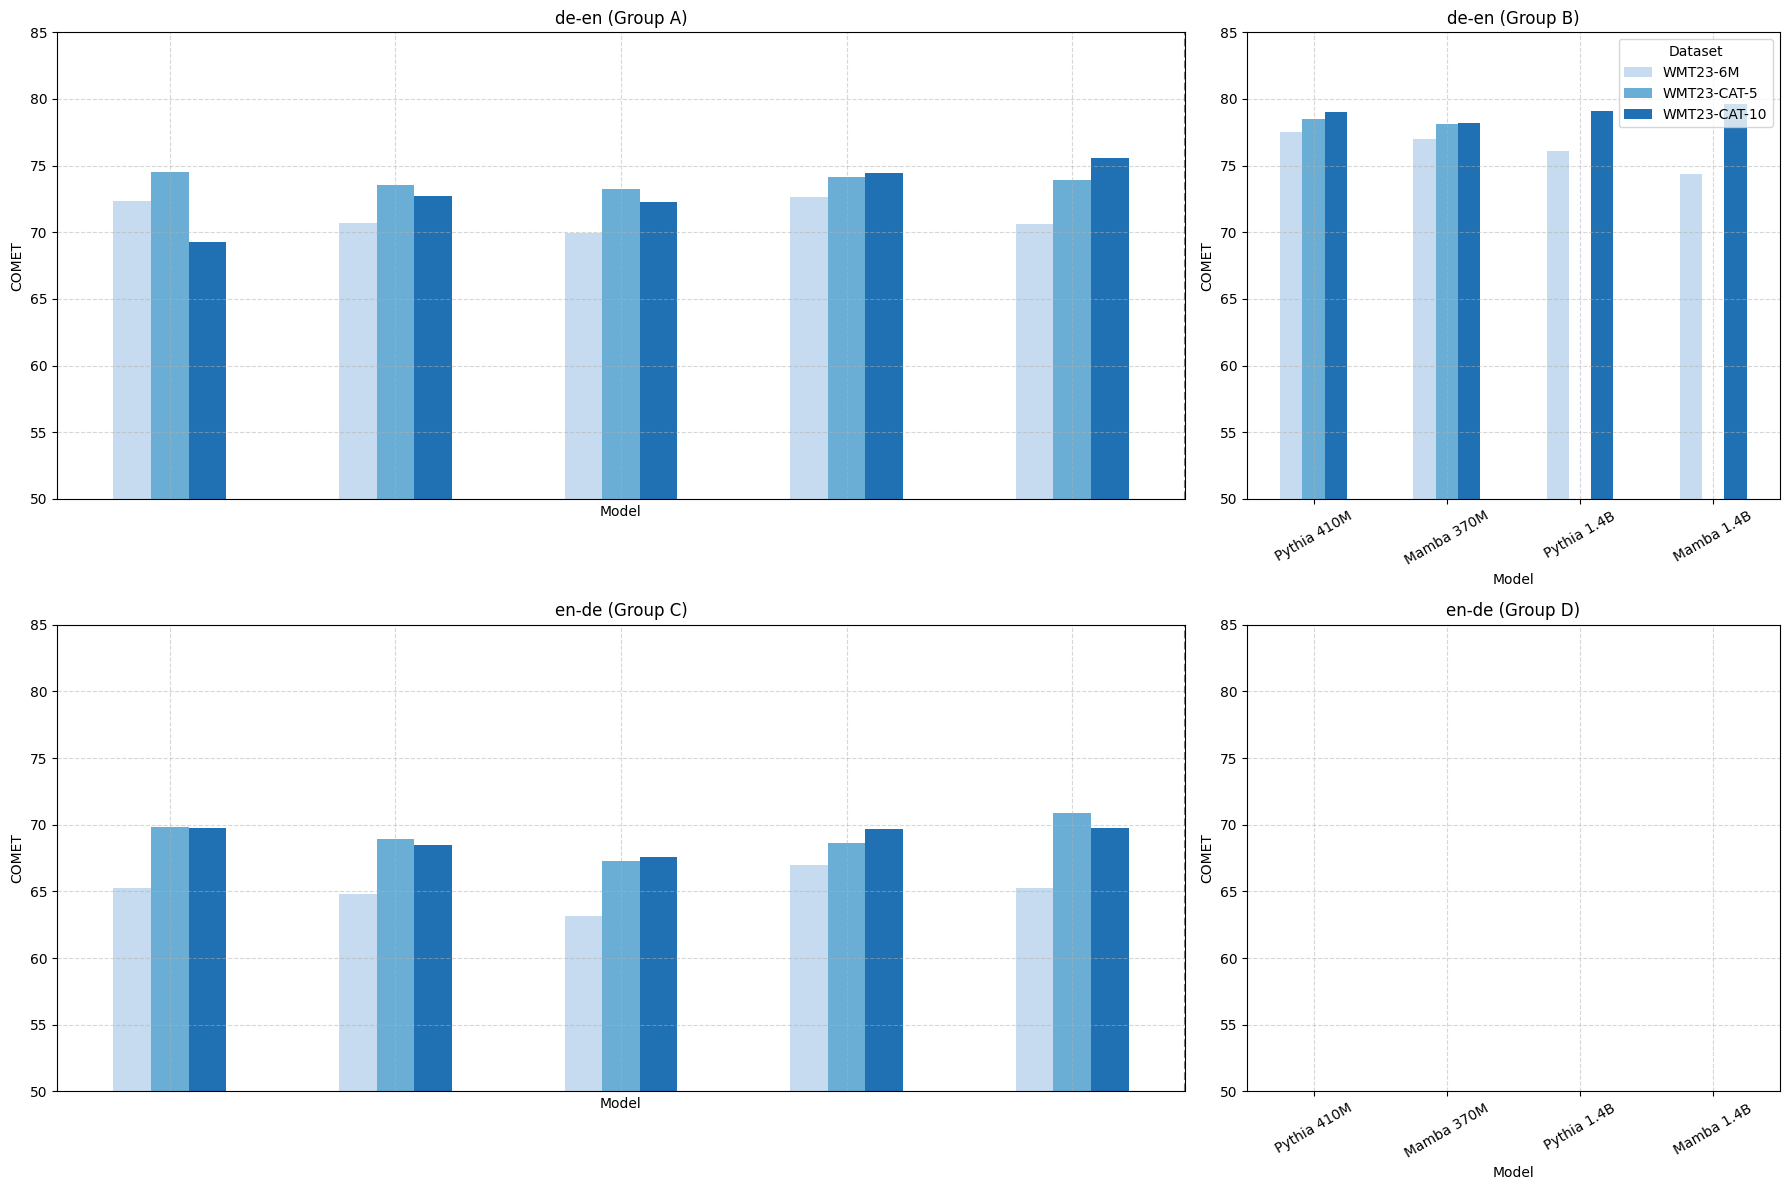

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import to_hex

# Lists for models and datasets
models = [
    "enc-dec tsf",
    "tsf++",
    "mamba",
    "mamba-mha",
    "mamba-encdec",
    "pythia (410M LLM + ft)",
    "mamba (370M LLM + ft)",
    "pythia (1.4B LLM + ft)",
    "mamba (1.4B LLM + ft)",
]

datasets = ["WMT23-6M", "WMT23-CAT-5", "WMT23-CAT-10"]

# COMET scores in a nested list format with placeholders for non-existing data
comet_scores = [
    # de-en
    [
        [72.34, 74.50, 69.29],  # enc-dec tsf
        [70.70, 73.52, 72.74],  # tsf++
        [69.93, 73.25, 72.24],  # mamba
        [72.68, 74.15, 74.47],  # mamba-mha
        [70.61, 73.95, 75.58],  # mamba-encdec
        [77.5, 78.5, 79.0],  # pythia (410M LLM + ft)
        [77.0, 78.1, 78.2],  # mamba (370M LLM + ft)
        [76.1, None, 79.1],  # pythia (1.4B LLM + ft)
        [74.4, None, 79.6],  # mamba (1.4B LLM + ft)
    ],
    # en-de
    [
        [65.23, 69.81, 69.76],  # enc-dec tsf
        [64.80, 68.93, 68.45],  # tsf++
        [63.17, 67.31, 67.61],  # mamba
        [66.95, 68.62, 69.71],  # mamba-mha
        [65.27, 70.88, 69.73],  # mamba-encdec
        [None, None, None],  # pythia (410M LLM + ft) - Placeholder
        [None, None, None],  # mamba (370M LLM + ft) - Placeholder
        [None, None, None],  # pythia (1.4B LLM + ft) - Placeholder
        [None, None, None],  # mamba (1.4B LLM + ft) - Placeholder
    ],
]

# Renaming the models for better display
model_rename = {
    "enc-dec tsf": "Transformer \n Encoder-Decoder",
    "tsf++": "Transformer++",
    "mamba": "Mamba",
    "mamba-mha": "Mamba-MHA",
    "mamba-encdec": "Mamba \n Encoder-Decoder",
    "pythia (410M LLM + ft)": "Pythia 410M",
    "mamba (370M LLM + ft)": "Mamba 370M",
    "pythia (1.4B LLM + ft)": "Pythia 1.4B",
    "mamba (1.4B LLM + ft)": "Mamba 1.4B",
}


# Preparing the data for plotting
def prepare_data(comet_scores, models, datasets, rename_dict):
    data = {"Model": [], "Dataset": [], "COMET": [], "Language Pair": []}
    for lang_idx, lang_pair in enumerate(["de-en", "en-de"]):
        for model_idx, model in enumerate(models):
            for dataset_idx, dataset in enumerate(datasets):
                score = comet_scores[lang_idx][model_idx][dataset_idx]
                data["Model"].append(rename_dict.get(model, model))
                data["Dataset"].append(dataset)
                data["COMET"].append(score)
                data["Language Pair"].append(lang_pair)
    return pd.DataFrame(data)


# Creating DataFrames for plotting
df = prepare_data(comet_scores, models, datasets, model_rename)

# Set the category order for the 'Model' column
df["Model"] = pd.Categorical(
    df["Model"], categories=[model_rename[m] for m in models], ordered=True
)

# Generate colors using the Blues color palette
colors = [
    to_hex(plt.cm.Blues(0.25)),
    to_hex(plt.cm.Blues(0.5)),
    to_hex(plt.cm.Blues(0.75)),
]

# Define the mosaic layout
mosaic = """
aab
ccd
"""

fig, axes = plt.subplot_mosaic(mosaic, figsize=(18, 12))

# Define model groups
groups = {
    "a": [
        "Transformer \n Encoder-Decoder",
        "Transformer++",
        "Mamba",
        "Mamba-MHA",
        "Mamba \n Encoder-Decoder",
    ],
    "b": ["Pythia 410M", "Mamba 370M", "Pythia 1.4B", "Mamba 1.4B"],
    "c": [
        "Transformer \n Encoder-Decoder",
        "Transformer++",
        "Mamba",
        "Mamba-MHA",
        "Mamba \n Encoder-Decoder",
    ],
    "d": ["Pythia 410M", "Mamba 370M", "Pythia 1.4B", "Mamba 1.4B"],
}

# Define language pairs
language_pairs = {
    "a": "de-en",
    "b": "de-en",
    "c": "en-de",
    "d": "en-de",
}

# Loop over the axes and plot the data
for key, ax in axes.items():
    group = groups[key]
    lang_pair = language_pairs[key]
    df_group = df[(df["Language Pair"] == lang_pair) & (df["Model"].isin(group))]
    pivot_group = df_group.pivot(index="Model", columns="Dataset", values="COMET")
    pivot_group = pivot_group[datasets]  # Reorder columns
    pivot_group.plot(kind="bar", ax=ax, legend=(key == "b"), color=colors)
    ax.set_title(f"{lang_pair} (Group {key.upper()})")
    ax.set_ylabel("COMET")
    if key in ["a", "c"]:
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )
    else:
        ax.tick_params(axis="x", rotation=30)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_ylim(50, 85)
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))

# Add dividers
for ax in axes.values():
    ax.axvline(4.5, color="grey", linestyle="--")
    if ax in [axes["a"], axes["b"]]:
        ax.axvline(6.5, color="grey", linestyle="--")

plt.tight_layout()
plt.show()

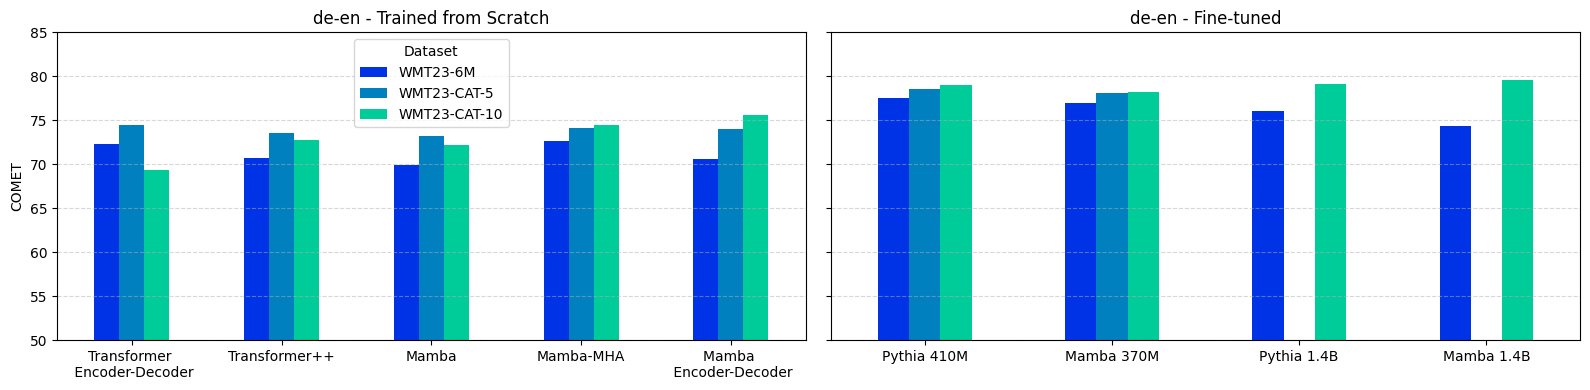

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import to_hex

# Lists for models and datasets
models = [
    "enc-dec tsf",
    "tsf++",
    "mamba",
    "mamba-mha",
    "mamba-encdec",
    "pythia (410M LLM + ft)",
    "mamba (370M LLM + ft)",
    "pythia (1.4B LLM + ft)",
    "mamba (1.4B LLM + ft)",
]

datasets = ["WMT23-6M", "WMT23-CAT-5", "WMT23-CAT-10"]

# COMET scores in a nested list format with placeholders for non-existing data
comet_scores = [
    # de-en
    [
        [72.34, 74.50, 69.29],  # enc-dec tsf
        [70.70, 73.52, 72.74],  # tsf++
        [69.93, 73.25, 72.24],  # mamba
        [72.68, 74.15, 74.47],  # mamba-mha
        [70.61, 73.95, 75.58],  # mamba-encdec
        [77.5, 78.5, 79.0],  # pythia (410M LLM + ft)
        [77.0, 78.1, 78.2],  # mamba (370M LLM + ft)
        [76.1, None, 79.1],  # pythia (1.4B LLM + ft)
        [74.4, None, 79.6],  # mamba (1.4B LLM + ft)
    ],
    # en-de
    [
        [65.23, 69.81, 69.76],  # enc-dec tsf
        [64.80, 68.93, 68.45],  # tsf++
        [63.17, 67.31, 67.61],  # mamba
        [66.95, 68.62, 69.71],  # mamba-mha
        [65.27, 70.88, 69.73],  # mamba-encdec
        [None, None, None],  # pythia (410M LLM + ft) - Placeholder
        [None, None, None],  # mamba (370M LLM + ft) - Placeholder
        [None, None, None],  # pythia (1.4B LLM + ft) - Placeholder
        [None, None, None],  # mamba (1.4B LLM + ft) - Placeholder
    ],
]

# Renaming the models for better display
model_rename = {
    "enc-dec tsf": "Transformer \n Encoder-Decoder",
    "tsf++": "Transformer++",
    "mamba": "Mamba",
    "mamba-mha": "Mamba-MHA",
    "mamba-encdec": "Mamba \n Encoder-Decoder",
    "pythia (410M LLM + ft)": "Pythia 410M",
    "mamba (370M LLM + ft)": "Mamba 370M",
    "pythia (1.4B LLM + ft)": "Pythia 1.4B",
    "mamba (1.4B LLM + ft)": "Mamba 1.4B",
}


# Preparing the data for plotting
def prepare_data(comet_scores, models, datasets, rename_dict):
    data = {"Model": [], "Dataset": [], "COMET": [], "Language Pair": []}
    for lang_idx, lang_pair in enumerate(["de-en", "en-de"]):
        for model_idx, model in enumerate(models):
            for dataset_idx, dataset in enumerate(datasets):
                score = comet_scores[lang_idx][model_idx][dataset_idx]
                data["Model"].append(rename_dict.get(model, model))
                data["Dataset"].append(dataset)
                data["COMET"].append(score)
                data["Language Pair"].append(lang_pair)
    return pd.DataFrame(data)


# Creating DataFrames for plotting
df = prepare_data(comet_scores, models, datasets, model_rename)

# Set the category order for the 'Model' column
df["Model"] = pd.Categorical(
    df["Model"], categories=[model_rename[m] for m in models], ordered=True
)

# Generate colors using the Blues color palette
colors = [
    to_hex(plt.cm.winter(0.2)),
    to_hex(plt.cm.winter(0.5)),
    to_hex(plt.cm.winter(0.8)),
]

# Create the bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharey=True)

model_groups = [
    [
        "Transformer \n Encoder-Decoder",
        "Transformer++",
        "Mamba",
        "Mamba-MHA",
        "Mamba \n Encoder-Decoder",
    ],
    ["Pythia 410M", "Mamba 370M", "Pythia 1.4B", "Mamba 1.4B"],
]


groups = ["Trained from Scratch", "Fine-tuned"]

# Plot for de-en
for j, (group, ax) in enumerate(zip(model_groups, axes)):
    df_group = df[(df["Language Pair"] == "de-en") & (df["Model"].isin(group))]
    pivot_group = df_group.pivot(index="Model", columns="Dataset", values="COMET")
    pivot_group = pivot_group[datasets]  # Reorder columns
    pivot_group.plot(kind="bar", ax=ax, legend=(j == 0), color=colors)

    ax.set_title(f"de-en - {groups[j]}")
    ax.set_ylabel("COMET")
    ax.set_xlabel('')  # Remove the x-axis label
    ax.tick_params(axis="x", rotation=0)

    ax.grid(True, axis="y", linestyle="--", alpha=0.5)
    ax.set_ylim(50, 85)  # Set y-axis limits
    ax.yaxis.set_major_locator(
        plt.MultipleLocator(5)
    )  # Set major ticks to every 5 units

plt.tight_layout()
plt.savefig("plots/wmt23-comet-de-en.pdf")
plt.show()


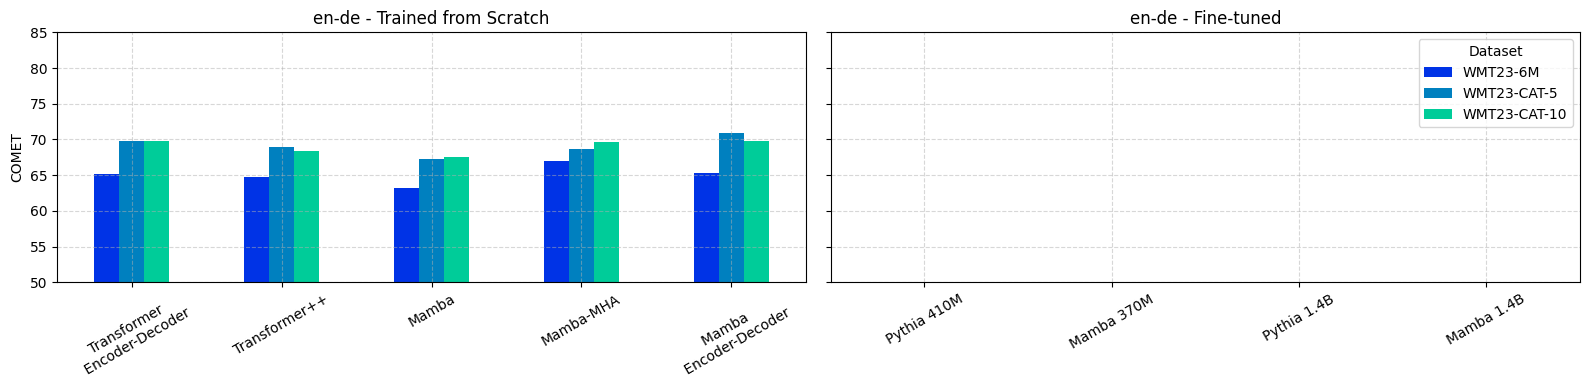

In [10]:
# Plot for en-de
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharey=True)

for j, (group, ax) in enumerate(zip(model_groups, axes)):
    df_group = df[(df["Language Pair"] == "en-de") & (df["Model"].isin(group))]
    pivot_group = df_group.pivot(index="Model", columns="Dataset", values="COMET")
    pivot_group = pivot_group[datasets]  # Reorder columns
    pivot_group.plot(kind="bar", ax=ax, legend=(j == 1), color=colors)

    ax.set_title(f"en-de - {groups[j]}")
    ax.set_ylabel("COMET")

    ax.set_xlabel('')  # Remove the x-axis label

    ax.tick_params(axis="x", rotation=30)
   
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_ylim(50, 85)  # Set y-axis limits
    ax.yaxis.set_major_locator(
        plt.MultipleLocator(5)
    )  # Set major ticks to every 5 units

plt.tight_layout()
plt.savefig("plots/wmt23-comet-en-de.pdf")
plt.show()